# Modelo Encoder - BERTIN

BERTIN es una serie de modelos basados ​​en BERT para español. El centro de modelos actual ofrece los mejores modelos basados ​​en RoBERTa, entrenados desde cero en la parte en español de mC4 con Flax .

In [ ]:
os.kill(os.getpid(), 9)

## Instalación e importación de librerías, y definición de constantes

In [ ]:
!pip install --force-reinstall numpy==1.26.4 --quiet
!pip install datasets --quiet

In [2]:
# Importación de librerías
import io
import time
import numpy as np

from torch.utils.data import DataLoader
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from transformers import AutoTokenizer
from transformers import AutoModel
from sklearn.model_selection import train_test_split

import pandas as pd
from sklearn.utils import resample
from torch.utils.data import DataLoader, random_split

import re
from datasets import Dataset, DatasetDict

from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, log_loss
from sklearn.neural_network import MLPClassifier

import warnings
warnings.filterwarnings("ignore")

# Configurar semillas para facilitar la reproducibilidad de los resultados
seed = 99
torch.manual_seed(seed)
np.random.seed(seed)

## 1. Tokenización

### 1.1. Carga de los datos

In [3]:
df = pd.read_excel('Data_final.xlsx')

Veamos el contenido de los primeros 10 items del dataset:

In [4]:
df.head()

ID                                              Texto Categoria  \
0   1  - ¡Rápido, necesitamos sangre! - Yo soy 0 posi...     Humor   
1   2  - ¿Cuál es el mejor portero del mundial?  - Ev...     Humor   
2   3  El otro día unas chicas llamarón a mi puerta y...     Humor   
3   4  - Andresito, ¿qué planeta va después de Marte?...     Humor   
4   5  - ¿Por qué Bob Esponja no va al gimnasio?  - P...     Humor   

   Categoría de 1 a 5    Dataset  
0                 4.0       test  
1                 3.0  train-val  
2                 3.0       test  
3                 4.0  train-val  
4                 1.0  train-val

### Eliminación de duplicados

In [5]:
print(df.shape)
df = df.drop_duplicates()
print(df.shape)

(11060, 5)
(11060, 5)


In [6]:
data = df[['ID', 'Texto', 'Categoria', 'Dataset']]

In [8]:
data.shape

(11060, 4)

In [9]:
data.head()

ID                                              Texto Categoria    Dataset
0   1  - ¡Rápido, necesitamos sangre! - Yo soy 0 posi...     Humor       test
1   2  - ¿Cuál es el mejor portero del mundial?  - Ev...     Humor  train-val
2   3  El otro día unas chicas llamarón a mi puerta y...     Humor       test
3   4  - Andresito, ¿qué planeta va después de Marte?...     Humor  train-val
4   5  - ¿Por qué Bob Esponja no va al gimnasio?  - P...     Humor  train-val

### Función de preprocesamiento

In [10]:
def preprocessing(text):
  #text = re.sub(r'[^a-zA-Z\s]', '', text)
  #text = re.sub(r'[.,]', '', text)
  text = text.lower()
  text = text.replace("\n", " ")
  text = text.replace("-", "")
  text = re.sub(r"[¿¡!?]", "", text)
  return text

data["Texto"] = data["Texto"].apply(preprocessing)
display(data[0:10])

ID                                              Texto Categoria    Dataset
0   1   rápido, necesitamos sangre  yo soy 0 positivo...     Humor       test
1   2   cuál es el mejor portero del mundial   eviden...     Humor  train-val
2   3  el otro día unas chicas llamarón a mi puerta y...     Humor       test
3   4   andresito, qué planeta va después de marte   ...     Humor  train-val
4   5   por qué bob esponja no va al gimnasio   porqu...     Humor  train-val
5   6  van dos ciegos y le dice uno al otro:   ojalá ...     Humor       test
6   7  noticia de última hora   muere una suegra atro...     Humor       test
7   8  – mamá, mamá, en el colegio dicen que estoy lo...     Humor  train-val
8   9  – mamá, mamá, me haces un bocata de jamón – yo...     Humor       test
9  10   qué pasa si te expulsan de cuatro univerdades...     Humor       test

Ajuste al formato de la librería datasets

In [11]:
# Mapear categorías a números
label_map = {"Humor": 1, "No Humor": 0}
data["label"] = data["Categoria"].map(label_map)

In [12]:
data['Dataset'].value_counts()

Dataset
train-val    9060
test         2000
Name: count, dtype: int64

In [13]:
# Seleccionar los datos de validación
test_df  = data.loc[data['Dataset'] =='test', ["Texto", "label"]].rename(columns={"Texto": "text"})

In [14]:
temp_df = data.loc[data['Dataset'] !='test', ["Texto", "label"]].rename(columns={"Texto": "text"})

In [15]:
# Dividir en train (82%), test (18%)
train_texts, val_texts, train_labels, val_labels = train_test_split(
    temp_df["text"], temp_df["label"], test_size=0.23, random_state=42, stratify=temp_df["label"]
)
train_df = pd.DataFrame({"text": train_texts, "label": train_labels})
val_df = pd.DataFrame({"text": val_texts, "label": val_labels})

In [16]:
print(f"Entrenamiento: {train_df.shape}, Validación: {val_df.shape}, Prueba: {test_df.shape}")

Entrenamiento: (6976, 2), Validación: (2084, 2), Prueba: (2000, 2)


In [17]:
train_dataset = Dataset.from_pandas(train_df)
val_dataset   = Dataset.from_pandas(val_df)
test_dataset  = Dataset.from_pandas(test_df)

dataset = DatasetDict({
    "train": train_dataset,
    "validation": val_dataset,
    "test": test_dataset
})

# Ver estructura final
print(dataset)

DatasetDict({
    train: Dataset({
        features: ['text', 'label', '__index_level_0__'],
        num_rows: 6976
    })
    validation: Dataset({
        features: ['text', 'label', '__index_level_0__'],
        num_rows: 2084
    })
    test: Dataset({
        features: ['text', 'label', '__index_level_0__'],
        num_rows: 2000
    })
})


### 1.2. Carga del tokenizador de distilbert

In [18]:
tokenizer = AutoTokenizer.from_pretrained("bertin-project/bertin-roberta-base-spanish")

tokenizer_config.json:   0%|          | 0.00/1.12k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/851k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/509k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.21M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/772 [00:00<?, ?B/s]

#### 1.2.2 Ejemplo tokenización

In [19]:
encoded_text = tokenizer('La tokenización de texto es una tarea central en PNL')
encoded_text

{'input_ids': [0, 496, 449, 19302, 1131, 313, 3487, 347, 405, 7341, 3750, 334, 45288, 2], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [20]:
tokens = tokenizer.convert_ids_to_tokens(encoded_text.input_ids)
tokens

['<s>',
 'La',
 'Ġto',
 'ken',
 'izaciÃ³n',
 'Ġde',
 'Ġtexto',
 'Ġes',
 'Ġuna',
 'Ġtarea',
 'Ġcentral',
 'Ġen',
 'ĠPNL',
 '</s>']

In [21]:
def tokenize(batch):
    return tokenizer(batch["text"], padding=True, truncation=True)

### 1.3 Tokenización del dataset

In [22]:
dataset_encoded = dataset.map(tokenize, batched=True, batch_size=None)

Map:   0%|          | 0/6976 [00:00<?, ? examples/s]

Map:   0%|          | 0/2084 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Revisamos las nuevas columnas con las que contamos

In [23]:
dataset_encoded['train'].column_names

['text', 'label', '__index_level_0__', 'input_ids', 'attention_mask']

In [24]:
model_ckpt = "bertin-project/bertin-roberta-base-spanish"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AutoModel.from_pretrained(model_ckpt).to(device)

config.json:   0%|          | 0.00/674 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at bertin-project/bertin-roberta-base-spanish and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [25]:
# Parámetros totales
total_params = sum(p.numel() for p in model.parameters())

print(f"Model size: {total_params} parameters")

Model size: 124643328 parameters


Prueba tokenización

In [26]:
text = "Esto es un texto"
sample_inputs = tokenizer(text, return_tensors="pt")
print(f"Input tensor shape: {sample_inputs['input_ids'].size()}\n"
      f"Tokenized text: {tokenizer.convert_ids_to_tokens(sample_inputs['input_ids'][0])}")

Input tensor shape: torch.Size([1, 6])
Tokenized text: ['<s>', 'Esto', 'Ġes', 'Ġun', 'Ġtexto', '</s>']


Prueba pasando el ejemplo tokenizado al modelo

In [27]:
inputs = {k:v.to(device) for k,v in sample_inputs.items()}

with torch.no_grad():
    outputs = model(**inputs)
    print(outputs)

BaseModelOutputWithPoolingAndCrossAttentions(last_hidden_state=tensor([[[ 0.0287, -0.0131, -0.0859,  ...,  0.0036, -0.0425,  0.0983],
         [-0.0508, -0.0113, -0.0418,  ..., -0.0262, -0.0359,  0.0961],
         [ 0.0325,  0.0326, -0.0882,  ..., -0.0118, -0.0728,  0.0534],
         [-0.0215, -0.0373, -0.0323,  ..., -0.0723, -0.0641,  0.0201],
         [-0.0145, -0.0358, -0.0490,  ..., -0.0189, -0.0751, -0.0025],
         [ 0.0124, -0.0269, -0.0690,  ..., -0.0370, -0.0545,  0.0568]]],
       device='cuda:0'), pooler_output=tensor([[ 7.3671e-02,  3.5566e-02, -7.8699e-02,  4.9215e-02,  5.1037e-02,
         -2.0908e-01, -8.5235e-02, -6.9140e-02, -5.7353e-02,  1.4064e-01,
         -7.2201e-02,  2.1808e-01, -8.7686e-02,  2.8476e-02,  9.2667e-02,
         -2.2656e-01, -1.3784e-01, -2.7854e-02, -7.6536e-02, -9.6364e-02,
          2.7694e-02, -2.4190e-02,  7.4971e-02,  7.5293e-02, -9.0594e-03,
         -1.0292e-01, -8.2700e-02,  1.6656e-01,  4.5047e-02,  3.0960e-02,
         -7.6035e-02,  2.3

In [28]:
outputs.last_hidden_state[:, 0].shape

torch.Size([1, 768])

Función que retorna solo el último estado oculto:

In [29]:
def extract_hidden_states(batch):
    inputs = {k:v.to(device) for k, v in batch.items()
    if k in tokenizer.model_input_names}
    with torch.no_grad():
        last_hidden_state = model(**inputs).last_hidden_state

    return {"hidden state": last_hidden_state[:, 0].cpu().numpy()}

### 1.4 Codificación del dataset

In [30]:
dataset_encoded.set_format("torch", columns=['input_ids', 'attention_mask', 'label'])

In [31]:
dataset_hidden = dataset_encoded.map(
    extract_hidden_states, batched=True, batch_size=8)

Map:   0%|          | 0/6976 [00:00<?, ? examples/s]

Map:   0%|          | 0/2084 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [32]:
X_train = np.array(dataset_hidden["train"]["hidden state"])
X_valid = np.array(dataset_hidden["validation"]["hidden state"])
X_test = np.array(dataset_hidden["test"]["hidden state"])
y_train = np.array(dataset_hidden["train"]["label"])
y_valid = np.array(dataset_hidden["validation"]["label"])
y_test = np.array(dataset_hidden["test"]["label"])
print(f"Entrenamiento: {X_train.shape}, Validación: {X_valid.shape}, Prueba: {X_test.shape}")

Entrenamiento: (6976, 768), Validación: (2084, 768), Prueba: (2000, 768)


## 2. Clasificación de los textos

In [33]:
clf = MLPClassifier(hidden_layer_sizes=(25,), max_iter=4, warm_start=True, random_state=42)

train_losses = []
val_losses = []

# Entrenar manualmente por época
for epoch in range(50):
    clf.fit(X_train, y_train)

    # Predicciones
    y_train_prob = clf.predict_proba(X_train)
    y_val_prob = clf.predict_proba(X_valid)

    # Cálculo de log-loss
    train_losses.append(log_loss(y_train, y_train_prob))
    val_losses.append(log_loss(y_valid, y_val_prob))

y_pred = clf.predict(X_test)
target_names = ['No Humor', 'Humor']
print(classification_report(y_test, y_pred, target_names=target_names))

              precision    recall  f1-score   support

    No Humor       0.90      0.96      0.92       804
       Humor       0.97      0.93      0.95      1196

    accuracy                           0.94      2000
   macro avg       0.93      0.94      0.94      2000
weighted avg       0.94      0.94      0.94      2000



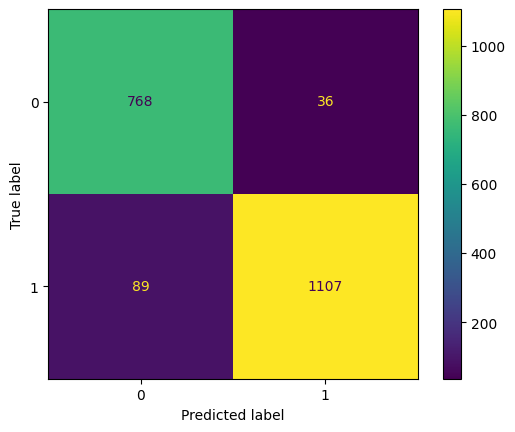

In [34]:
cm = confusion_matrix(y_test, y_pred, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=clf.classes_)
disp.plot()
plt.show()

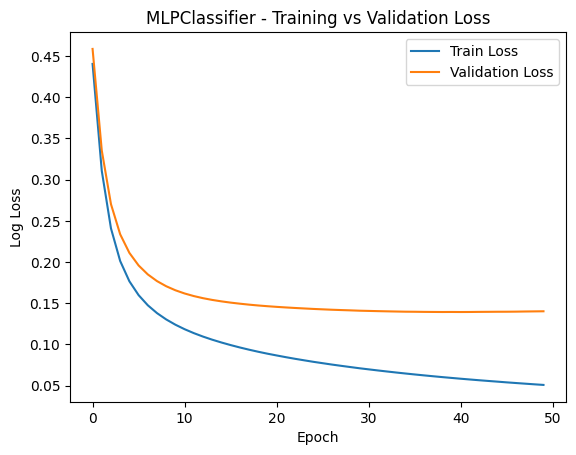

In [35]:
# Graficar
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Log Loss")
plt.title("MLPClassifier - Training vs Validation Loss")
plt.legend()
plt.show()

In [36]:
print(val_losses[-1])
print(train_losses[-1])

0.1402750687246286
0.05096281446942948


## Prueba adicional utilizando Regresión logística para clasificación

In [37]:
from sklearn.linear_model import LogisticRegression
lr_clf = LogisticRegression(max_iter=3000, random_state=42)
lr_clf.fit(X_train, y_train)

LogisticRegression(max_iter=3000, random_state=42)

## 4. Conjunto de datos para pruebas de estrés

In [38]:
stress = pd.read_excel('stress_data_1.xlsx')

In [39]:
stress.columns

Index(['Ejemplos', 'Texto', 'Label', 'Clase_Contraria', 'Incoherentes',
       'Repeticion', 'ofuscamiento', 'Largo', 'Corto'],
      dtype='object')

In [40]:
stress["Texto"] = stress["Texto"].apply(preprocessing)

In [41]:
stress['Label'].value_counts()

Label
No Humor    50
Humor       50
Name: count, dtype: int64

In [42]:
# Mapear categorías a números
label_map = {"Humor": 1, "No Humor": 0}
stress["label"] = stress["Label"].map(label_map)

# Seleccionar solo las columnas necesarias
df_stress = stress[["Texto", "label"]].rename(columns={"Texto": "text"})  # Formato compatible con datasets

In [43]:
St_dataset = Dataset.from_pandas(df_stress)

St_encoded = St_dataset.map(tokenize, batched=True, batch_size=None)
St_encoded.set_format("torch", columns=['input_ids', 'attention_mask', 'label'])

St_hidden = St_encoded.map(extract_hidden_states, batched=True, batch_size=8)

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

In [44]:
St_hidden.column_names

['text', 'label', 'input_ids', 'attention_mask', 'hidden state']

In [45]:
X_St = np.array(St_hidden["hidden state"])
Y_St = np.array(St_hidden["label"]).astype(int)

In [46]:
y_pred_st = clf.predict(X_St)
y_pred_st

array([0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0,
       1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0,
       0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1,
       0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1])

In [47]:
stress['Pred'] = y_pred_st

In [48]:
stress.head(100)

Ejemplos                                              Texto     Label  \
0          1       hombre le pregunta a su mujer como va a casa  No Humor   
1          2  señor, usted tiene hijos —preguntó el niño. sí...  No Humor   
2          3  un niño observaba a un hombre mayor en la plaz...  No Humor   
3          4  jaimito le hace una pregunta a su madre: mamá,...  No Humor   
4          5  pregunta pregunta pregunta pregunta pregunta p...  No Humor   
..       ...                                                ...       ...   
95        96    después de la tormenta, siempre llega la calma.  No Humor   
96        97  el amor nos impulsa a hacer cosas que nunca cr...  No Humor   
97        98  el amor puede volver loco a cualquiera, pero t...  No Humor   
98        99  voy en busca de la paz interior que me permita...  No Humor   
99       100  el invierno llegó con fuerza este año, cubrien...  No Humor   

   Clase_Contraria Incoherentes Repeticion ofuscamiento Largo Corto  label  \
0               SI          NaN        NaN          NaN    NO    SI      0   
1               SI          NaN        NaN          NaN    SI    NO      0   
2               SI          NaN        NaN          NaN    SI    NO      0   
3               SI          NaN        NaN          NaN    SI    NO      0   
4               SI          NaN        NaN          NaN    NO    SI      0   
..             ...          ...        ...          ...   ...   ...    ...   
95              SI          NaN        NaN          NaN    NO    SI      0   
96              SI          NaN        NaN          NaN    NO    SI      0   
97              SI          NaN        NaN          NaN    SI    NO      0   
98              SI          NaN        NaN          NaN    NO    SI      0   
99              SI          NaN        NaN          NaN    NO    SI      0   

    Pred  
0      0  
1      1  
2      1  
3      1  
4      0  
..   ...  
95     0  
96     0  
97     1  
98     1  
99     1  

[100 rows x 11 columns]

In [49]:
print(classification_report(Y_St, y_pred_st, target_names=target_names))

              precision    recall  f1-score   support

    No Humor       0.61      0.46      0.52        50
       Humor       0.56      0.70      0.62        50

    accuracy                           0.58       100
   macro avg       0.58      0.58      0.57       100
weighted avg       0.58      0.58      0.57       100



In [50]:
stress_contrary = stress[stress["Clase_Contraria"]=="SI"]

Y_St = stress_contrary["label"]
y_pred_st = stress_contrary["Pred"]

print(classification_report(Y_St, y_pred_st, target_names=target_names))

              precision    recall  f1-score   support

    No Humor       0.52      0.52      0.52        25
       Humor       0.70      0.70      0.70        40

    accuracy                           0.63        65
   macro avg       0.61      0.61      0.61        65
weighted avg       0.63      0.63      0.63        65



In [51]:
stress_incoherent = stress[stress["Incoherentes"]=="SI"]

Y_St = stress_incoherent["label"]
y_pred_st = stress_incoherent["Pred"]

print(classification_report(Y_St, y_pred_st, target_names=target_names))

              precision    recall  f1-score   support

    No Humor       1.00      0.30      0.46        10
       Humor       0.00      0.00      0.00         0

    accuracy                           0.30        10
   macro avg       0.50      0.15      0.23        10
weighted avg       1.00      0.30      0.46        10



In [55]:
stress_rep = stress[stress["Repeticion"]=="SI"]

Y_St = stress_rep["label"]
y_pred_st = stress_rep["Pred"]

print(classification_report(Y_St, y_pred_st, target_names=target_names))

              precision    recall  f1-score   support

    No Humor       0.70      0.70      0.70        10
       Humor       0.70      0.70      0.70        10

    accuracy                           0.70        20
   macro avg       0.70      0.70      0.70        20
weighted avg       0.70      0.70      0.70        20



In [52]:
stress_ofus = stress[stress["ofuscamiento"]=="SI"]

Y_St = stress_ofus["label"]
y_pred_st = stress_ofus["Pred"]

print(classification_report(Y_St, y_pred_st, target_names=target_names))

              precision    recall  f1-score   support

    No Humor       0.00      0.00      0.00       5.0
       Humor       0.00      0.00      0.00       0.0

    accuracy                           0.00       5.0
   macro avg       0.00      0.00      0.00       5.0
weighted avg       0.00      0.00      0.00       5.0



In [53]:
stress_long = stress[stress["Largo"]=="SI"]

Y_St = stress_long["label"]
y_pred_st = stress_long["Pred"]

print(classification_report(Y_St, y_pred_st, target_names=target_names))

              precision    recall  f1-score   support

    No Humor       0.25      0.11      0.15        19
       Humor       0.60      0.81      0.68        31

    accuracy                           0.54        50
   macro avg       0.42      0.46      0.42        50
weighted avg       0.46      0.54      0.48        50



In [54]:
stress_short = stress[stress["Corto"]=="SI"]

Y_St = stress_short["label"]
y_pred_st = stress_short["Pred"]

print(classification_report(Y_St, y_pred_st, target_names=target_names))

              precision    recall  f1-score   support

    No Humor       0.70      0.68      0.69        31
       Humor       0.50      0.53      0.51        19

    accuracy                           0.62        50
   macro avg       0.60      0.60      0.60        50
weighted avg       0.62      0.62      0.62        50

